In [3]:
!pip install tensorly

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import tensorly

In [6]:
#scarichiamo il nostro database
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
#scegliamo la nostra immagine di test
label_test = 5
#lavoriamo sul dataset di test
Dataset_test=np.asarray(mnist.test.images).reshape(10000,28,28)
DTest_num=Dataset_test[(mnist.test.labels[:,label_test])==1,:,:]
test_range=DTest_num.shape[0]
test_range

892

In [8]:
import tensorly.decomposition
#carichiamo le immagini di training ed estraiamone solo quelle di un numero
Dataset_image=np.asarray(mnist.train.images).reshape(55000,28,28) #riassettiamo il tensore delle dimensioni che vogliamo
residuo_matrix=np.zeros((40,10))
residuo_matrix.shape

(40, 10)

In [15]:
for t_range in range(40):    
    for label in range(10):
        #Percent = []
        #lable è il nostro numero di controllo
        #carichiamo il dataset di training per le immagini dove l'immagine ha la nostra lable
        Dataset_num= Dataset_image[(mnist.train.labels[:,label])==1,:,:]
        Dataset_num.shape #per sapere com'è composto il dataset

        #prendiamo solo 150 elementi del dataset imagini relativo al numero
        porzione=150
        Dataset_num=Dataset_num[:porzione,:,:]
        #per controllare Dataset_num.shape

        #scegliamo la nostra immagine di test
        label_test = 5
        #lavoriamo sul dataset di test
        Dataset_test=np.asarray(mnist.test.images).reshape(10000,28,28)
        DTest_num=Dataset_test[(mnist.test.labels[:,label_test])==1,:,:]
        #prendiamo una a caso tra le nostre immagini di test relative alla label numero 5
        rand_img=DTest_num[t_range,:,:];

        #DECOMPOSIZIONE DI TUCKER lavorando sul dataset di training
        #lavorando con python dobbiamo permutare gli assi per far quadrare i calcoli
        Dataset_num = np.transpose(Dataset_num)
        numero_base=porzione #è il numero della dimensione del nostro core tensor
        core, factors=tensorly.decomposition.non_negative_tucker(Dataset_num,rank=[28,28,numero_base],init='svd')#inseriamo come rango le dimensioni del core tensor

        #prepariamo il confronto
        #diamo il numero di basi e dopo creiamo la matrice con un numero di zeri uguali alla base calcolata
        Temp=np.zeros(rand_img.shape)#Creiamo l'immagine vuota della stessa granzezza del numero preso per il test
        num_basi=core.shape[2] #150 perchè la misura del core è (28.28.150)
        tensore_basi=np.zeros(num_basi)#abbiamo costruito un tensore con 150 elementi vuoti

        #calcoliamo la nostra approssimazione X dove la prima matrice è la più significativa
        for i in range(40):#studiare le percentuali per poter stabilire il giusto range--------------
            X=tensorly.tenalg.mode_dot(core[:,:,i],factors[0], mode=0) #prodotto modo 1 tensore - matrice fattore A
            X=tensorly.tenalg.mode_dot(X,factors[1],mode=1)#prodotto modo 2 del tensore precedente- matrice fattore B
            X=np.transpose(X)
            tensore_basi[i]=np.sum(rand_img*X)/np.sum(X*X)
            Temp = Temp + tensore_basi[i]*X 
        #percentuale di vicinanza
        #percentuale_label=100.*(1.- (tensorly.norm(rand_img-Temp)**2/tensorly.norm(rand_img)**2))
        residuo_base=tensorly.norm(rand_img-Temp)**2/tensorly.norm(rand_img)**2
        #inserisco le percentuali di vicinanza su array
        #Percent.insert(label,percentuale_label)
        residuo_matrix[t_range][label]=residuo_base
        #inserisco nella matrice dei residui le percentuali(da rivedere)


In [10]:
#Programma che prende degli input e restituisce due liste, le basi e le percentuali di vicinanza tra il nostro test e le basi.
#Controllare per tutti i range fino a 150 di 10 in 10 la differenza tra la massima percentuale e la percentuale media di differenza in modo
#da poter stabilire quale sia scientificamente la linea di range più consona. stabilita quella verrà usata come linea di base provata

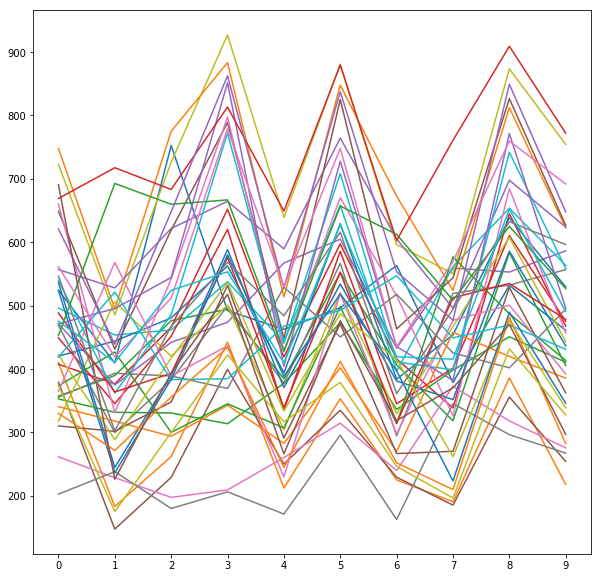

In [12]:
import matplotlib.pyplot as plt
transp=np.transpose(residuo_matrix)
fig = plt.figure(figsize=(10,10))
plt.xticks(np.linspace(0,9,10,endpoint=True))
plt.plot(transp)
plt.savefig("test_residuo(5)_nnt.png")

In [13]:
#Facciamo una statistica sull'efficacia del metodo
numero_statistica=0
for i in residuo_matrix:
    minimo_lista=min(i)
    for j in range(10):
        if (i[j] == minimo_lista and j==5):
            numero_statistica = numero_statistica +1
tot_perc=100*numero_statistica/150
print(str(tot_perc)+"%")

0.0%


In [15]:
#valori singolari modo 3
(size_im1,size_im2, num_im) = core.shape
sz =np.zeros(num_im)
for j in range(num_im):
   sz[j]= numpy.linalg.norm(core[:,:,j],'fro')

Text(0,0.5,'Singular values')

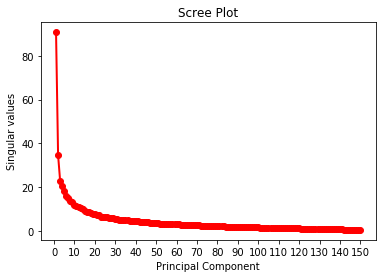

In [16]:
fig = plt.figure(figsize=(6,4))
sing_vals = np.arange(num_im) + 1
plt.plot(sing_vals, sz, 'ro-', linewidth=2)
plt.xticks(np.arange(0, 160, step=10))
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Singular values')


Populating the interactive namespace from numpy and matplotlib


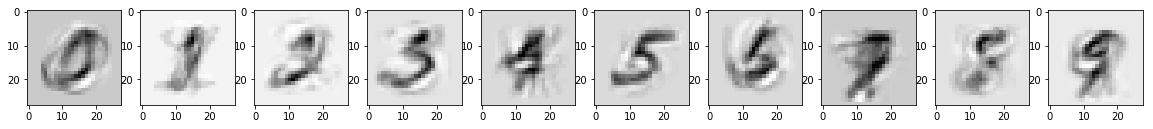

In [11]:
%pylab inline
f = plt.figure(figsize=(20,20));
for i in range(len(Basi)):
    subplot(1,len(Basi),i+1)
    imshow(Basi[i], cmap='Greys', interpolation='None')